#### GISC 425 T1 2020
# **Assignment 3 Data processing using `dictionary` objects**

In [3]:
# You need to run this cell to get things setup
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot

import geopandas

In this assignment you are asked to use a data dictionary to perform relatively complicated processing of a data set to make it more useful for mapping and analysis.

## Background information
The dataset we will be using is the Land Resource Inventory (LRI) which was digitized in the 1970s and includes extensive information on land use capability (or suitability), erosion,
geology, soils, and vegetation. LRI is a valuable resource for any work looking into changes in
land use over time. However, the form in which the attribute data for this database was recorded is a product of a time when computer memory and storage was at a premium. As a result very complex information about each map unit is recorded in a format that presents difficulties for present day users of the data interested in making even simple land capability, vegetation, soil or geological maps.

The particular data attribute we are interested in is Landuse Capability (LUC) which has been encoded in the format

    abcc+abcc
    
where the second part of this code may not always be present. The first four characters encode the dominant landuse capability assessment, and the second set of four (after the `+` sign) encode a subdominant capability where this has been assessed.

The characters in the assessment code are interpreted as explained below. First, the letter `a` denotes the Landuse Class as tabulated below

`a` | Landuse class
:--:|:-------------
1 2 3 or 4 | Arable
5 6 or 7 | Non-arable
8 | Protected

Next the letter `b` denotes the Landuse limitation

`b` | Landuse limitation
:--:|:------------------
c | Climate
e | Erosion
s | Soil
w | Wetness

Finally, the two characters `cc` are a two digit number ranking and associating various categories of land use suitability. Detailed interpretation of the number is beyond our scope in this assignment. Details can be found in:

+ Noble, K. E., 1985. *Land Use Capability Classification of the Southern Hawke’s Bay-Waiarapa
Region: A Bulletin to Accompany New Zealand Land Resource Inventory Worksheets*. Land
Resource Group Soil Conservation Centre, Aokautere, Ministry of Works and Development,
Palmerston North.

The four character `abcc` code may appear twice separated by a `+` character, in which
case the first set of four indicates the dominant land use capability assessment and the second
set a subdominant assessment.

Finally, 'non-normal' land units are coded as follows

Code | Meaning
:----|:-------
estu | Estuary
ice | Ice
lake | Lake
quar | Quarries/mines
rive | River
town | Town/urban


### So what's the problem?
So, for example the code

    3e 7+5e 5
    
decodes to

    Dominant class:          Arable
    Dominant limitation:     Erosion
    Dominant suitability:    7
    Subdominant class:       Non-arable
    Subdominant limitation:  Erosion
    Subdominant suitability: 5
    
That's a lot of information encoded in a single attribute, and you can maybe see why we would want to break it out into new variables in the dataset.

To see the problem even more clearly, we will read in a sample of the data (this is a national dataset, but it's useful to look at just a subset to get the idea).

In [4]:
d = geopandas.read_file('wairarapa_s_hawkes_bay.geojson')

d

,LUC,ROCK,SOIL,geometry
0,6s 4,Gr,b56GS,"MULTIPOLYGON (((1889278.093 5619255.656, 18893..."
1,8e 5,Gw,b33B +BRock,"MULTIPOLYGON (((1889753.910 5618752.989, 18897..."
2,6e 6,Mo/Gw,b55A,"MULTIPOLYGON (((1889019.238 5619058.900, 18891..."
3,8e 5,Gw,b33C,"MULTIPOLYGON (((1888603.124 5618613.895, 18886..."
4,6s 1,Gr+Us,b38 +42B,"MULTIPOLYGON (((1900430.537 5618914.104, 19004..."
...,...,...,...,...
6768,7s 1,Gr+Gw,* 1c +BRock,"MULTIPOLYGON (((1794584.035 5392534.051, 17946..."
6769,rive,rive,!rive,"MULTIPOLYGON (((1788358.332 5392488.772, 17884..."
6770,7e10,Gw+Ac,*122 +BRock,"MULTIPOLYGON (((1790228.676 5392290.775, 17902..."
6771,7s 1,Gr+Wb,* 1c +BRock,"MULTIPOLYGON (((1788110.234 5392072.863, 17882..."


and

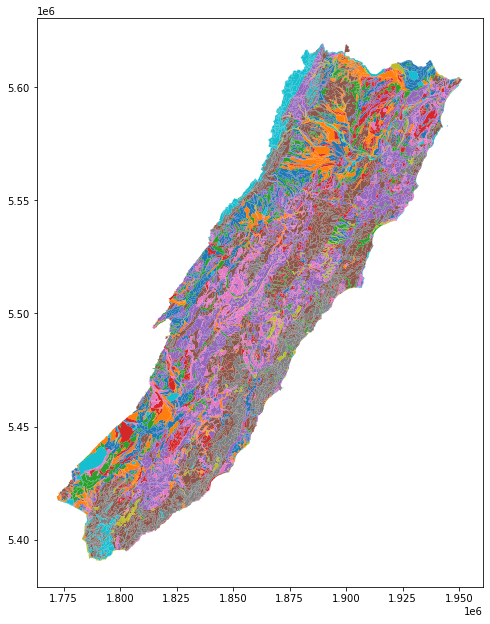

In [5]:
d.plot(column='LUC', figsize=(8,11), linestyle='None')

Pretty map, but to get some idea of the problem, take a close look at the `LUC` column in the data table.

In [6]:
d

,LUC,ROCK,SOIL,geometry
0,6s 4,Gr,b56GS,"MULTIPOLYGON (((1889278.093 5619255.656, 18893..."
1,8e 5,Gw,b33B +BRock,"MULTIPOLYGON (((1889753.910 5618752.989, 18897..."
2,6e 6,Mo/Gw,b55A,"MULTIPOLYGON (((1889019.238 5619058.900, 18891..."
3,8e 5,Gw,b33C,"MULTIPOLYGON (((1888603.124 5618613.895, 18886..."
4,6s 1,Gr+Us,b38 +42B,"MULTIPOLYGON (((1900430.537 5618914.104, 19004..."
...,...,...,...,...
6768,7s 1,Gr+Gw,* 1c +BRock,"MULTIPOLYGON (((1794584.035 5392534.051, 17946..."
6769,rive,rive,!rive,"MULTIPOLYGON (((1788358.332 5392488.772, 17884..."
6770,7e10,Gw+Ac,*122 +BRock,"MULTIPOLYGON (((1790228.676 5392290.775, 17902..."
6771,7s 1,Gr+Wb,* 1c +BRock,"MULTIPOLYGON (((1788110.234 5392072.863, 17882..."


Among the 6773 rows in this table, there are

In [7]:
len(set(d['LUC']))

105

Yes... that's right, 105, unique codes! Although it is clear from the quick map we made above that there is useful spatial structure in these data, mapping and visulization is made difficult by so much information being summarised in a single (complex) encoding.

What we are aiming for is a way to unpack this information, per the tables in the previous section into  new variables each showing dominant and subdominant landuse class, landuse limitation, and landuse ranking. \[You can probably see that there's a similar problem lurking in the information contained in the `ROCK` and `SOIL` variables, but we'll leave that for some other time.]

In [8]:
# Before continuing we'll read an even smaller dataset for testing
d = geopandas.read_file('sample_lri.geojson')

## An outline solution
There are probably a hundred different ways to approach this problem. I'm going to outline one approach, which you can follow. If you are feeling adventurous (and confident) feel free to tackle it in a different way. This is how I would do it.

**First** write a function that takes as input a LUC code, and depending on the parameters, returns dominant or subdominant landuse class, landuse limitation or landuse suitability&mdash;that's six different possible outcomes. It will also be fine if we end up with six smaller simpler functions, each of them capable of decoding a single new variable.

**Second** ... well... that's kind of the whole plan! 

The question is how to execute it.

Here are some things to consider.

### Dictionaries as translators
We've seen in the book how a dictionary can be used to translate between two languages, or in our situation how it can be used to map keys in the encoded data to values that we want in our output data. For example, if we had a dictionary with

    dictionary['town'] = 'Town/urban'
    
then it can do a small bit of the translation we need.  Similarly, provided we know that we are trying to determine the landuse class, a dictionary that decodes an input `1`, `2`, `3`, or `4` as `Arable` would also be useful. Same goes for one that can handle the landuse limitation. The suitability is a bit different. Since those are two digit numeric codes it's fine just to retain them as 

So... I suggest that the first thing to do is build a dictionary that can do most of the decoding for us. Start work on this in the cell below.

### **Build your translator `dict` here**

In [9]:
## Setup a dictionary to do the hard work of the decoding
## It's OK if it can only handle some cases to begin 
## It's also OK to make two or three simple dictionaries 
## rather than one big complicated one
## Look at the tables in the Background information section 
## back at the top of this notebook for inspiration

## I've made a start on one of them for you below

non_normals= {'estu' : 'Estuary','ice' : 'Ice: ','lake' : 'Lake','quar' : 'Quarries/mines', 'rive' : 'River','towlaken' : 'Town/urban'}

lu_classes=  {'1': 'Arable','2': 'Arable','3': 'Arable','4': 'Arable', '5': 'Non-Arable','6': 'Non-Arable','7': 'Non-Arable','8' : 'Protected'}

lu_limits={'c': 'Climate','e': 'Erosion','s': 'Soil', 'w': 'Wetness'}

print()


### Adding new variables to a `GeoDataFrame`
This is pretty easy, as it turns out. We simply do

    d['NewVariableName'] = ...
    
where we obviously need to fill in the `...` with some result from a function.

This is where `geopandas` is a big help. Instead of looping through every value in the `LUC` column of the dataset if we have some function (say) `decode_landuse_class` then we can do this:

    d.LUC.apply(decode_landuse_class)
    
to apply it to the `LUC` codes.  So in this case

    d['DOM_LUCLASS`] = d.LUC.apply(decode_landuse_class)
    
would do the trick. That suggests we need some functions...

### Simple functions for each of the six possible decodings
We want to decode the `LUC` codes to six different new variables, so at least to begin, this suggests making six (simple) functions that can take a `LUC` code and convert it to a value appropriate for whichever of the six new variables we want.

There is likely to be scope for combining functions given that the dominant and subdominant assessment codes are the same (each is made up of four characters encoded identically, just before and after the `+` sign). But this is a refinement. To begin with, writing six simple functions that handle just one of the decoding operations will be perfectly fine.

Again, I've made a start in the cell below.

### **Build functions to do the conversions here**

In [10]:
# function to return the dominant landuse class
# given a LUC code
def dom_landuse(code):
    if code in non_normals:
        return non_normals[code]
    else:
        return lu_classes[code[0]] # this won't work yet, because 'lu_classes' dict does not exist
    
def subdominant_landuse(code):
    if code in non_normals:
        return ''
    else:
        return lu_limits[code[1]]

## You'll need to write functions for the other new variables also 


### Making it work
The cell below shows how this would work for one variable

### **Add to the code below to do all the needed conversions**

In [11]:
d['DOM_LUCLASS'] = d.LUC.apply(dom_landuse) # This won't work because work is needed above

And here is how to plot it to check your handiwork.

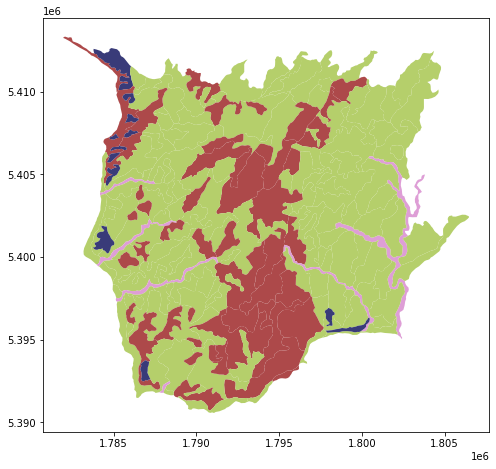

In [12]:
fig = pyplot.figure(figsize=(8,11))

ax1 = fig.add_subplot(111)
d.plot(ax=ax1, column='DOM_LUCLASS', cmap='tab20b')

## Submission instructions
Once you have all the parts working, in the various cells above, double check everything by resetting the notebook and running everything from a newly reopened copy.

Then put everything (dictionary, functions, commands to run the functions) in the single cell below.

Also, this time, **add comments to your code**. This is to help me assess how well you understand what you are doing, and will be an important part of the grading.

Finally, save the notebook, ensuring your name is included in the filename, and submit via the dropbox provided on Blackboard. The assignment is due on **10 April at 5:00PM**.

In [13]:
# importing the reqiured packages to decode land use cover via import function

%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot

import geopandas

## --------------------------------------------------------------------------
## Initiatlise the dictionary here:
## --------------------------------------------------------------------------


variable_limitation=['Landuse limitation','Climate','Erosion','Soil', 'Wetness'] # list from square brackets[];naming limitation variable
code_limitation=['b','c','e','s','w'] # 
dictionary_limitation=dict(zip(code_limitation,variable_limitation)) # zip function converts 2 list variables to a dictionary 


variable_name_non_normal=['Estuary','Ice','Lake','Quarries/mines', 'River','Town/urban']
code_non_normal=['estu','ice','lake','quar','rive','town']
non_normals=dict(zip(code_non_normal,variable_name_non_normal)) # zip function converts 2 list variables to a dictionary

variable_name_LUC=['Arable','Arable','Arable','Arable', 'Non-Arable','Non-Arable','Non-Arable','Non-Arable', 'Protected']
code_LUC=['1','2','3','4','5','6','7','8']
dictionary_LUC=dict(zip(code_LUC,variable_name_LUC))# zip function converts 2 list variables to a dictionary



In [14]:

## --------------------------------------------------------------------------
## Provide function definitions here:
## --------------------------------------------------------------------------

# function to return the dominant landuse class
# each def function is connected with each other; e.g. without first def dom_landuse function then the rest will not work. 
def dom_landuse(code): # defining the dominant land use function with one value/variable inside it. 
    if code in non_normals:# if the value/code is inside the non-normal dominant land use then:
        return non_normals[code] # the non-normal dictionary with be returned 
    else: # if the code inside don_landuse doesnt return non_normals[code] then: 
        return dictionary_LUC[code[0]] # allows 'lu_classes' dict to exist and uses dom_landuse code with 0 index
    
def dom_limit(second_code): # defining dominant limitation
    if second_code in non_normals: # if the value inside dom_limit def function is in non_normal dictionary than:
        return non_normals[second_code] # compute the dominant limitation code/value inside non normal dictionary
    else: # if not than: 
        return dictionary_limitation[second_code[1]] # creates the dominant limitation code with 1 index inside the limitation dictionary
    

def dom_suit(third_code): # defining dominant suitability function with one variable inside the brackets 
    if third_code in non_normals: # if the dominant suitability variable contains non normal dictionary then:
        return -1 # convert the non normal dictionary to an interger; simple to plot
    else: # if not then: 
        return int(third_code[2:4]) # compute an dominant suitability interger value of index ranging from 2 to 3
                                    # e.g. get code cc from "abcc + abcc" via slice(start:stop[:step])
                                                           
def subdominant_landuse(forth_code):  # defining sudominant land use function with one variable inside the brackets 
    if forth_code in non_normals:# if the sudominant land use variable contains non normal dictionary then:
        return non_normals[forth_code] # generate the sudominant land use code/value inside non_normals dictionary  
    elif len(forth_code)>= 6: # if not, then use the length of subdominant_landuse value that is greater than or equal to 6 then:
        # if the length of code( "abcc + abcc") is greater than or equal to 6 indcates a subdominant
        return dictionary_LUC[forth_code[5]] # generate land use dictornary containing subdominant_landuse with an index of 5; 
                                                         # e.g. get code a from "abcc + abcc"; 6th arrangment as 0 is included  
    else:                                                                                    
        return 'Extra' # if not, then create the legend name 'extra', for land use (subdominant)
    
    
def subdominant_limit(fifth_code): # defining sudominant limitation function with one variable inside the brackets 
    if fifth_code in non_normals:# if the sudominant limitation variable contains non normal dictionary then:
        return non_normals[fifth_code] # produce sudominant limitation code/value inside non_normals dictionary  
    elif len(fifth_code)>= 6: # if not, then use sudominant limitation code/value length less than or equal to 6: # explained above
        return dictionary_limitation[fifth_code[6]] # to create limitation dictornary containing subdominant_limit with an index of 6
    else:
        return 'Extra' # legend name 'extra', for land use limitation (subdominant), if code is less than 5 than value is not a subdominat class  e.g  abcc 
    
     
def subdominant_suit(sixth_code): # defining subdominant suitability function with one variable inside the brackets 
    if sixth_code in non_normals: # if the sudominant limitation variable contains non normal dictionary then:
        return -1 # returning and converting a non_normals to a integer
    elif len(sixth_code)>= 6: # if the length of subdominant is greater of equal to 6 than:
        return int(sixth_code[7:9]) # return the integer # from index 7 to 8  via slice(start:stop[:step])
    else:
        return -1 # returning a integer value as suitability contains numbers; excellent for plot a map without  a cmap. 
    

In [15]:
# Start by reading the data
d = geopandas.read_file('wairarapa_s_hawkes_bay.geojson')

# adding the LUC columns numbers to 6 columns via the defined functions (above).
# creating row names via d["row name"] from the def function. 
d['DOM_LUCLASS'] = d.LUC.apply(dom_landuse) # Labeling dominant landuse as ,"DOM_LUCLASS"; repeating the same for the reminding 5 LUC. 
d['DOM_LULIMITATION'] = d.LUC.apply(dom_limit) # Labeling dominant limitation  as ,"DOM_LULIMITATION";
d['DOM_LUSUITABILITY'] = d.LUC.apply(dom_suit) # Labeling dominant suitability  as ,"DOM_LUSUITABILITY";
d['SUBDOM_LUCLASS'] = d.LUC.apply(subdominant_landuse) # Labeling subdominant landuse as ,"SUBDOM_LUCLASS";
d['SUBDOM_LULIMITATION'] = d.LUC.apply(subdominant_limit) # Labeling subdominant limitation  as ,"SUBDOM_LULIMITATION";
d['SUBDOM_LUSUITABILITY'] = d.LUC.apply(subdominant_suit) # Labeling subdominant suitability  as ,"SUBDOM_LUSUITABILITY";

d # generating a table shown below

,LUC,ROCK,SOIL,geometry,DOM_LUCLASS,DOM_LULIMITATION,DOM_LUSUITABILITY,SUBDOM_LUCLASS,SUBDOM_LULIMITATION,SUBDOM_LUSUITABILITY
0,6s 4,Gr,b56GS,"MULTIPOLYGON (((1889278.093 5619255.656, 18893...",Non-Arable,Soil,4,Extra,Extra,-1
1,8e 5,Gw,b33B +BRock,"MULTIPOLYGON (((1889753.910 5618752.989, 18897...",Non-Arable,Erosion,5,Extra,Extra,-1
2,6e 6,Mo/Gw,b55A,"MULTIPOLYGON (((1889019.238 5619058.900, 18891...",Non-Arable,Erosion,6,Extra,Extra,-1
3,8e 5,Gw,b33C,"MULTIPOLYGON (((1888603.124 5618613.895, 18886...",Non-Arable,Erosion,5,Extra,Extra,-1
4,6s 1,Gr+Us,b38 +42B,"MULTIPOLYGON (((1900430.537 5618914.104, 19004...",Non-Arable,Soil,1,Extra,Extra,-1
...,...,...,...,...,...,...,...,...,...,...
6768,7s 1,Gr+Gw,* 1c +BRock,"MULTIPOLYGON (((1794584.035 5392534.051, 17946...",Non-Arable,Soil,1,Extra,Extra,-1
6769,rive,rive,!rive,"MULTIPOLYGON (((1788358.332 5392488.772, 17884...",River,River,-1,River,River,-1
6770,7e10,Gw+Ac,*122 +BRock,"MULTIPOLYGON (((1790228.676 5392290.775, 17902...",Non-Arable,Erosion,10,Extra,Extra,-1
6771,7s 1,Gr+Wb,* 1c +BRock,"MULTIPOLYGON (((1788110.234 5392072.863, 17882...",Non-Arable,Soil,1,Extra,Extra,-1


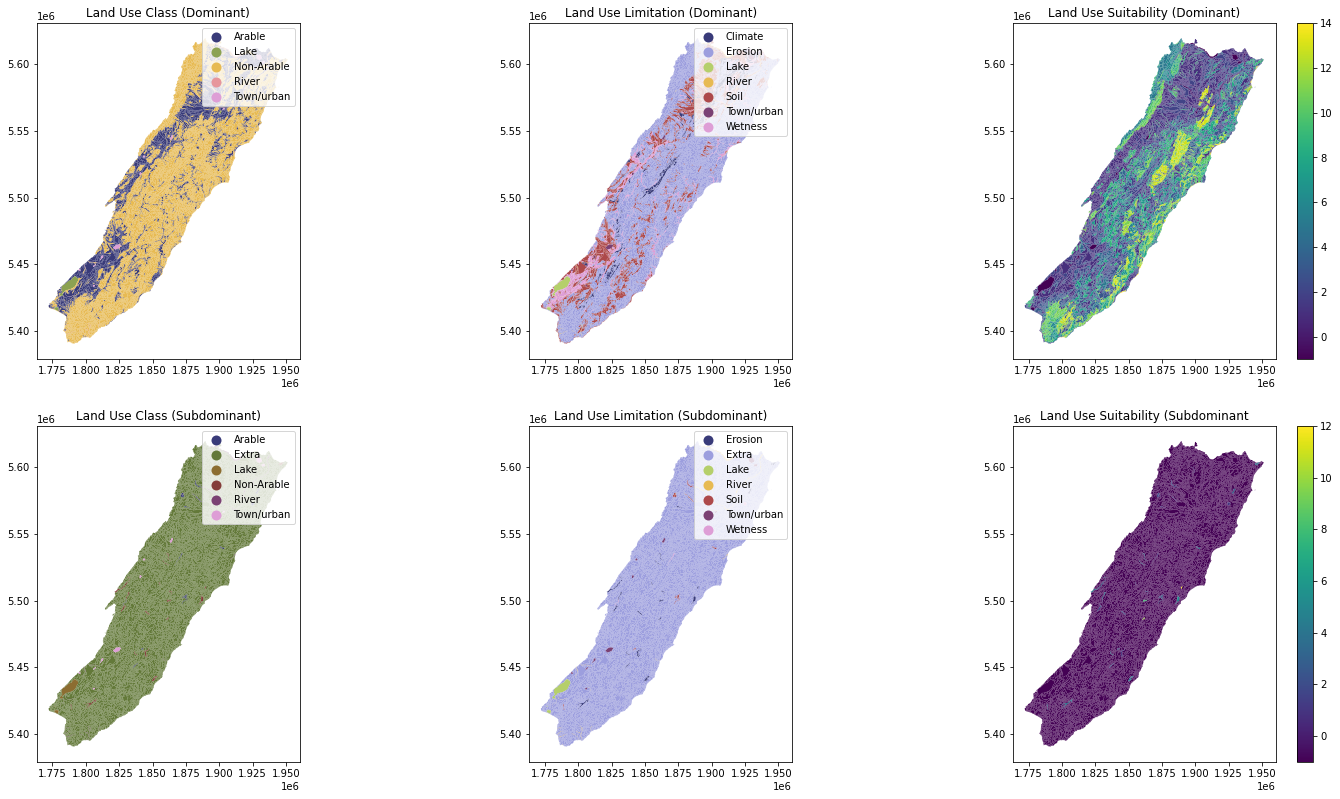

In [18]:
# testing the translation process and creating maps  

fig = pyplot.figure(figsize=(25,21))# creating a figure with a figure size of 25 (width) by 21 (height)

ax1 = fig.add_subplot(331) # arangement:  1st left at the top
ax1.set_title('Land Use Class (Dominant)')
d.plot(ax=ax1, column='DOM_LUCLASS', cmap='tab20b', legend="TRUE")

ax2 = fig.add_subplot(332) # arangement:  2nd left at the top
ax2.set_title('Land Use Limitation (Dominant)') # title
d.plot(ax=ax2, column='DOM_LULIMITATION', cmap='tab20b',legend="TRUE") # creating a plot whereby:
# aranged ax=ax2 plots the figure a the arranged area, column= plots the Land Use Limitation (Dominant) generated from above
# cmap= adding the ,'tab20b', setting and legend="TRUE" creates a legend


ax3 = fig.add_subplot(333)# arangement:  3rd left at the top
ax3.set_title('Land Use Suitability (Dominant)')  # title
d.plot(ax=ax3, column='DOM_LUSUITABILITY',legend="TRUE") # # no cmap is added as DOM_LUSUITABILITY is an integer value


ax4 = fig.add_subplot(334)  # arangement:  1st left at the bottom
ax4.set_title('Land Use Class (Subdominant)') # title
d.plot(ax=ax4, column='SUBDOM_LUCLASS', cmap='tab20b',legend="TRUE")


ax5 = fig.add_subplot(335)  # arangement:  2nd left at the bottom
ax5.set_title('Land Use Limitation (Subdominant)')  # title
d.plot(ax=ax5, column='SUBDOM_LULIMITATION', cmap='tab20b',legend="TRUE")


ax6 = fig.add_subplot(336) # arangement:  3rd left at the bottom
ax6.set_title('Land Use Suitability (Subdominant')  # title
d.plot(ax=ax6, column='SUBDOM_LUSUITABILITY',legend="TRUE") # no cmap is added as SUBDOM_LUSUITABILITY is an integer value

# generating 6 figures via fig.add_subplot() from 331-336